Import Part

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot
from scipy import stats
from pandas import DataFrame

Const

In [2]:
FILE_NAME = 'vegas.csv'

Loading dataset

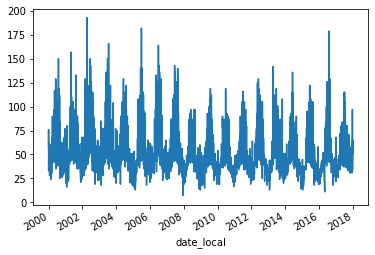

6007  entries


In [5]:
df = pd.read_csv(os.path.join(FILE_NAME), header=0, index_col=0)
df.index = pd.to_datetime(df.index)
df = df.sort_values('date_local', ascending=True)
df['aqi'].plot()
pyplot.show()
total = len(df)
print(total, " entries")

Sliding window

In [11]:
STEP = 4
values = DataFrame(df.values)
dataframe = DataFrame()
dataframe = pd.concat([values.shift(i) for i in range(STEP, -1, -1)], axis=1)
columns = []
for i in range(STEP, -1, -1):
    t = f"t-{i}" if i != 0 else "t"
    columns.extend([f"{t}-x{j}" for j in range(1, len(df.columns) + 1)])

columns = columns[:-1] + ["y"]
dataframe.columns = columns 
dataframe = dataframe.dropna()
dataframe

,t-4-x1,t-4-x2,t-4-x3,t-4-x4,t-3-x1,t-3-x2,t-3-x3,t-3-x4,t-2-x1,t-2-x2,t-2-x3,t-2-x4,t-1-x1,t-1-x2,t-1-x3,t-1-x4,t-x1,t-x2,t-x3,y
4,1.142105,71.0,0.032647,59.0,0.000000,106.0,0.030412,76.0,0.370833,36.0,0.010000,33.0,1.162500,64.0,0.009000,55.0,1.158333,50.0,0.026118,46.0
5,0.000000,106.0,0.030412,76.0,0.370833,36.0,0.010000,33.0,1.162500,64.0,0.009000,55.0,1.158333,50.0,0.026118,46.0,0.420833,42.0,0.011647,39.0
6,0.370833,36.0,0.010000,33.0,1.162500,64.0,0.009000,55.0,1.158333,50.0,0.026118,46.0,0.420833,42.0,0.011647,39.0,1.775000,67.0,0.007412,57.0
7,1.162500,64.0,0.009000,55.0,1.158333,50.0,0.026118,46.0,0.420833,42.0,0.011647,39.0,1.775000,67.0,0.007412,57.0,2.208333,66.0,0.004647,56.0
8,1.158333,50.0,0.026118,46.0,0.420833,42.0,0.011647,39.0,1.775000,67.0,0.007412,57.0,2.208333,66.0,0.004647,56.0,1.091667,46.0,0.004941,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6002,0.983333,59.0,0.007471,53.0,1.033333,67.0,0.008412,57.0,1.220833,83.0,0.008412,65.0,1.091667,65.0,0.004353,56.0,1.123529,56.0,0.007471,51.0
6003,1.033333,67.0,0.008412,57.0,1.220833,83.0,0.008412,65.0,1.091667,65.0,0.004353,56.0,1.123529,56.0,0.007471,51.0,0.891667,63.0,0.006647,55.0
6004,1.220833,83.0,0.008412,65.0,1.091667,65.0,0.004353,56.0,1.123529,56.0,0.007471,51.0,0.891667,63.0,0.006647,55.0,0.970833,60.0,0.006412,53.0
6005,1.091667,65.0,0.004353,56.0,1.123529,56.0,0.007471,51.0,0.891667,63.0,0.006647,55.0,0.970833,60.0,0.006412,53.0,0.987500,59.0,0.005588,53.0


Training model

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

In [13]:
X = dataframe.values[:, :-1]
y = dataframe.values[:, -1]

train_max_index = int(len(X) * 0.8)
Xtrain = X[: train_max_index]
ytrain = y[: train_max_index]
Xtest = X[train_max_index:]
ytest= y[train_max_index:]

Ensemble preparation

In [14]:
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge


In [15]:

# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=False)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(Xtrain):
	# split data
	X_train, X_test = Xtrain[train_ix, :], Xtrain[test_ix, :]
	y_train, y_test = ytrain[train_ix], ytrain[test_ix]
	# configure the cross-validation procedure
	cv_inner = KFold(n_splits=3, shuffle=False)
	# define the model
	estimators = [
		('dt', DecisionTreeRegressor()),
		('linreg', LinearRegression()),
		('ridge', Ridge())
	]

	model = StackingRegressor(estimators=estimators , final_estimator=RandomForestRegressor(n_estimators=500, random_state=42))
	# define search space
	space = dict()
	space['dt__criterion'] = ['friedman_mse', 'absolute_error', 'squared_error']
	space['dt__max_depth'] = [2, 4, 8, 12]
	space['ridge__alpha'] = [0.1, 0.2, 0.4, 0.8, 1]
	# define search
	search = GridSearchCV(model, space, scoring='neg_root_mean_squared_error', cv=cv_inner, refit=True, n_jobs=-1)
	# execute search
	result = search.fit(X_train, y_train)
	# get the best performing model fit on the whole training set
	best_model = result.best_estimator_
	# evaluate model on the hold out dataset
	yhat = best_model.predict(X_test)
	# evaluate the model
	acc = mean_squared_error(y_test, yhat, squared=False)
	# store the result
	outer_results.append(acc)
	# report progress
	print('>rmse=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('RMSE: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>rmse=13.439, est=-12.910, cfg={'dt__criterion': 'friedman_mse', 'dt__max_depth': 8, 'ridge__alpha': 1}
>rmse=14.068, est=-12.614, cfg={'dt__criterion': 'squared_error', 'dt__max_depth': 12, 'ridge__alpha': 0.8}
>rmse=14.810, est=-12.563, cfg={'dt__criterion': 'squared_error', 'dt__max_depth': 12, 'ridge__alpha': 0.8}
>rmse=14.938, est=-12.674, cfg={'dt__criterion': 'friedman_mse', 'dt__max_depth': 8, 'ridge__alpha': 0.4}
>rmse=14.514, est=-12.696, cfg={'dt__criterion': 'friedman_mse', 'dt__max_depth': 8, 'ridge__alpha': 1}
>rmse=12.879, est=-12.933, cfg={'dt__criterion': 'friedman_mse', 'dt__max_depth': 8, 'ridge__alpha': 0.2}
>rmse=8.838, est=-13.329, cfg={'dt__criterion': 'absolute_error', 'dt__max_depth': 12, 'ridge__alpha': 0.4}
>rmse=12.236, est=-13.019, cfg={'dt__criterion': 'friedman_mse', 'dt__max_depth': 12, 'ridge__alpha': 1}
>rmse=11.859, est=-13.057, cfg={'dt__criterion': 'squared_error', 'dt__max_depth': 12, 'ridge__alpha': 0.4}
>rmse=9.696, est=-13.389, cfg={'dt__criteri

In [18]:
estimators = [
		('dt', DecisionTreeRegressor(criterion='absolute_error', max_depth=12)),
		('linreg', LinearRegression()),
		('ridge', Ridge(alpha=0.4))
	]

model2 = StackingRegressor(estimators=estimators, n_jobs=-1, final_estimator=RandomForestRegressor(n_estimators=500, random_state=42))
model2.fit(Xtrain, ytrain)
pred = model2.predict(Xtest)
print(mean_squared_error(ytest, pred, squared=False))

12.088622287340895
